In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import platform
from IPython.display import display, clear_output, HTML
from datetime import datetime
import pickle

from time import sleep
from tqdm.auto import tqdm
from utils import logger, rule_base_predict

import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver import Firefox, ActionChains
from selenium.webdriver.common.keys import Keys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import numba

START_TS = datetime.now()

2021-05-19 21:36:27,168 -INFO - config:config.py:16 - Module utils.config was loaded
2021-05-19 21:36:27,169 -INFO - common:common.py:422 - Module utils.common is loaded...
2021-05-19 21:36:27,170 -INFO - common:common.py:549 - Module utils.common is loaded...
2021-05-19 21:36:27,171 -INFO - dataset_builder:dataset_builder.py:16 - dataset package is loaded...
2021-05-19 21:36:27,809 -INFO - dataset:dataset.py:627 - dataset package is loaded...


In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window, get_parents_list, build_tree_dict, DatasetBuilder

In [3]:
selenium.__version__

'3.141.0'

## Parameters

2021-05-19 21:36:27,861 -INFO - dataset_builder:dataset_builder.py:122 - Dataset name: ozon
2021-05-19 21:36:27,862 -INFO - dataset_builder:dataset_builder.py:131 - Create directories to save the dataset
2021-05-19 21:36:27,863 -INFO - dataset_builder:dataset_builder.py:166 - Creating driver
2021-05-19 21:36:28,944 -INFO - dataset_builder:dataset_builder.py:174 - Chrome web driver is created
2021-05-19 21:36:29,064 -INFO - <ipython-input-4-10d69dc0fb1f>:<ipython-input-4-10d69dc0fb1f>:11 - getting url: https://www.ozon.ru/category/smartfony-15502/?from_global=true&rsdiagonalstr=1.000%3B10.000&text=%D1%81%D0%BC%D0%B0%D1%80%D1%82%D1%84%D0%BE%D0%BD%D1%8B
2021-05-19 21:36:36,277 -INFO - dataset_builder:dataset_builder.py:177 - save scrinshot: dataset/images/ozon.png
2021-05-19 21:36:37,582 -INFO - dataset_builder:dataset_builder.py:221 - Collect features using JS script
2021-05-19 21:36:41,253 -INFO - dataset_builder:dataset_builder.py:229 - Save html to dataset/html/ozon.html
2021-05-19 21

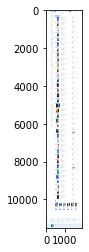

In [4]:
SITE_URL = 'https://www.ozon.ru/category/smartfony-15502/?from_global=true&rsdiagonalstr=1.000%3B10.000&text=%D1%81%D0%BC%D0%B0%D1%80%D1%82%D1%84%D0%BE%D0%BD%D1%8B'
DATASET_NAME = 'ozon'
class JDIDatasetBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        driver.set_window_size(width=1920, height=11500)
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        #maximize_window(driver=driver, extend_pix=0)
        

with JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))



In [5]:
df = pd.read_parquet('dataset/df/ozon.parquet')

In [6]:
controls_df = rule_base_predict(df)
controls_df

2021-05-19 21:36:43,251 -INFO - common:common.py:483 - Num radio buttons found: 4
2021-05-19 21:36:43,251 -INFO - common:common.py:487 - Num checkboxes found: 103
2021-05-19 21:36:43,261 -INFO - common:common.py:493 - Num comboboxes/dropdowns found: 1
2021-05-19 21:36:43,268 -INFO - common:common.py:499 - Num textfields found: 1
2021-05-19 21:36:43,272 -INFO - common:common.py:504 - Num texfields for numbers found: 1
2021-05-19 21:36:43,277 -INFO - common:common.py:509 - Num ranges found: 10
2021-05-19 21:36:43,282 -INFO - common:common.py:514 - Num ordinary text inputs found: 10
2021-05-19 21:36:43,284 -INFO - common:common.py:517 - Num buttons found: 132
2021-05-19 21:36:43,289 -INFO - common:common.py:521 - Num links found: 299


element_id      x       y  width  height  label
538  4498887957493975887136065818  248.5   451.5    0.0     0.0      7
544  1516131416493975885125317101  248.5   479.0    0.0     0.0      7
552  8103089213493975882202604662  248.5   506.5    0.0     0.0      7
558  2361401408493975888389668690  248.5   532.5    0.0     0.0      7
567  8683606599493975887364940066  401.5   574.0   13.0    13.0      5
..                            ...    ...     ...    ...     ...    ...
799  4418814594493975883344953089  243.5  2019.0  190.0    24.0     14
817  8683669941493975886039033473  243.5  2151.0  190.0    24.0     14
818  4008201520493975884874849919  243.5  2151.0  190.0    24.0     14
908  0524967597493975886876628372  243.5  2763.0  190.0    24.0     14
909  3589728952493975889648585454  243.5  2763.0  190.0    24.0     14

[561 rows x 6 columns]

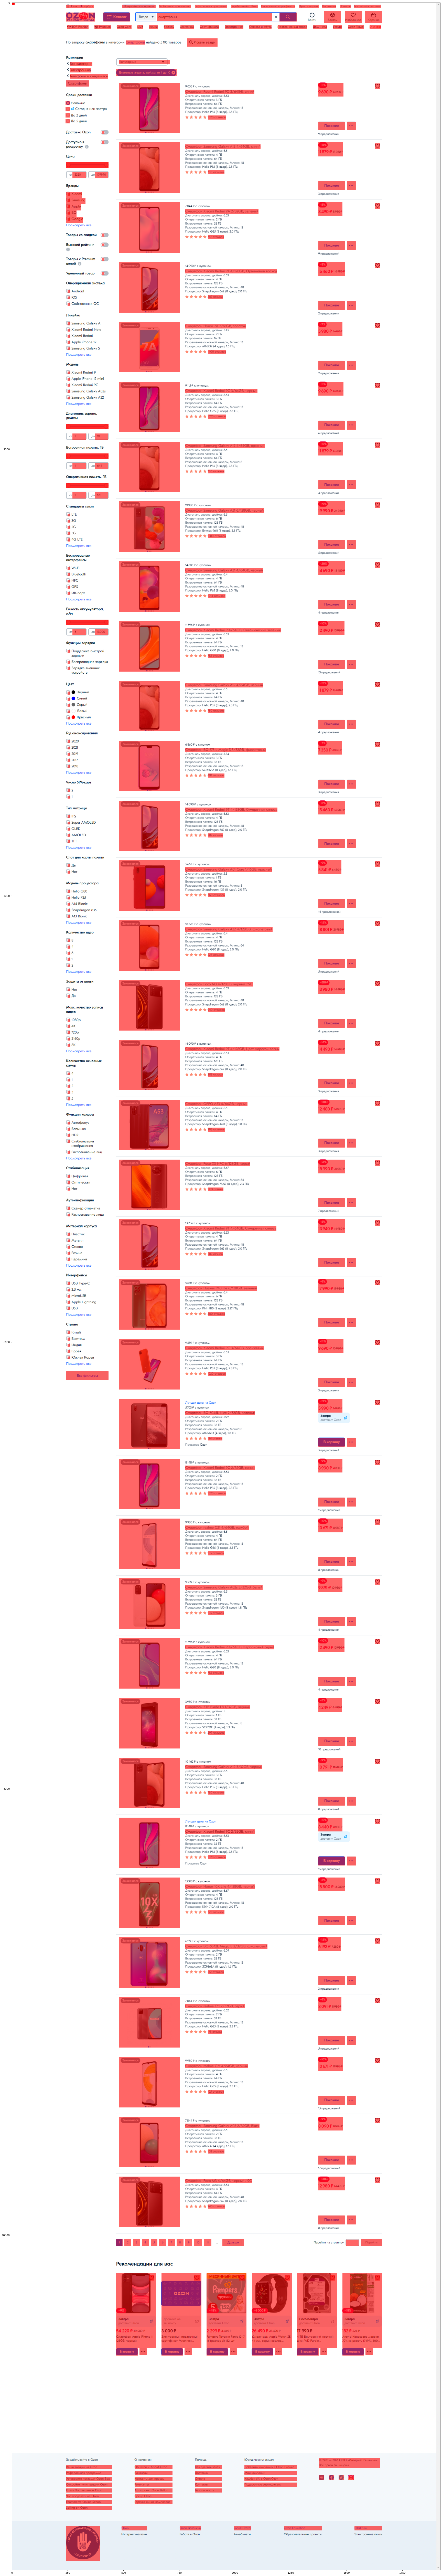

In [7]:
plt.figure(figsize=(30,200))
img = plt.imread('dataset/images/ozon.png')
plt.imshow(img)
axes = plt.gca()

COLUMNS = ['element_id', 'x', 'y', 'width', 'height']

def display_controls(df: pd.DataFrame, axes=axes, color='red'):
    for r in df.iterrows():
        idx, ( uuid, x, y, w, h) = r

        if w == 0:
            w += 20 
            x -= 8
        if h == 0:
            h += 20 
            y -= 12

        patch = patches.Rectangle((x,y), w, h, linewidth=2, alpha = .6, facecolor = color)
        axes.add_patch(patch)
        # print(idx, x, y, w, h)
    
display_controls(controls_df[COLUMNS])


In [29]:
controls_df[['label', 'X', 'Y', 'W', 'H']] #.to_csv('dataset/annotations/ozon.txt', sep=' ', header=False, index=False)

KeyError: "['H', 'W', 'X', 'Y'] not in index"

In [57]:
def to_yolo(x:int, y:int, w:int, h:int):
    if x<=0 and y<=0 and w==0 and h == 0:
        return [0,0,0,0]
    if w == 0:
        w += 20
    if h == 0:
        h += 20
    x -= 8
    y -= 12
    return [x, y, w, h]
        
    
to_yolo(**{ 'x': 0, 'y': 0, 'w': 0, 'h': 0})

[0, 0, 0, 0]

In [58]:
controls_df.apply(lambda r: to_yolo(x=r['x'], y=r['y'], w=r['width'], h=r['height']), axis=1)

538      [240.5, 439.5, 20.0, 20.0]
544      [240.5, 467.0, 20.0, 20.0]
552      [240.5, 494.5, 20.0, 20.0]
558      [240.5, 520.5, 20.0, 20.0]
567      [393.5, 562.0, 13.0, 13.0]
                   ...             
799    [235.5, 2007.0, 190.0, 24.0]
817    [235.5, 2139.0, 190.0, 24.0]
818    [235.5, 2139.0, 190.0, 24.0]
908    [235.5, 2751.0, 190.0, 24.0]
909    [235.5, 2751.0, 190.0, 24.0]
Length: 561, dtype: object

In [44]:
controls_df

element_id      x       y  width  height  label  \
538  0944598936352514393630987965  248.5   451.5    0.0     0.0      7   
544  7880071416352514397632259066  248.5   479.0    0.0     0.0      7   
552  9301761613352514391398762472  248.5   506.5    0.0     0.0      7   
558  2022559949352514396913453980  248.5   532.5    0.0     0.0      7   
567  6604693406352514398171187217  401.5   574.0   13.0    13.0      5   
..                            ...    ...     ...    ...     ...    ...   
799  1495750215352514399633681281  243.5  2019.0  190.0    24.0     14   
817  8769777421352514398653038450  243.5  2151.0  190.0    24.0     14   
818  7601175306352514391834337943  243.5  2151.0  190.0    24.0     14   
908  0735296595352514398864417962  243.5  2763.0  190.0    24.0     14   
909  0789586175352514393854220604  243.5  2763.0  190.0    24.0     14   

          text_label         X         Y         W         H  
538  radiobutton_btn  0.129427  0.039261  0.000000  0.000000  
544  radiobutton_btn  0.129427  0.041652  0.000000  0.000000  
552  radiobutton_btn  0.129427  0.044043  0.000000  0.000000  
558  radiobutton_btn  0.129427  0.046304  0.000000  0.000000  
567     checkbox_btn  0.212500  0.050478  0.006771  0.001130  
..               ...       ...       ...       ...       ...  
799            range  0.176302  0.176609  0.098958  0.002087  
817            range  0.176302  0.188087  0.098958  0.002087  
818            range  0.176302  0.188087  0.098958  0.002087  
908            range  0.176302  0.241304  0.098958  0.002087  
909            range  0.176302  0.241304  0.098958  0.002087  

[561 rows x 11 columns]